In [3]:
# https://www.kdnuggets.com/2018/11/keras-long-short-term-memory-lstm-model-predict-stock-prices.html

import numpy as np
import matplotlib.pyplot as plt
# Plotly
import plotly.plotly as py
import plotly.tools as tls
import pandas as pd
from datetime import datetime
from requests_html import HTMLSession
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
import time
import tensorflow as tf

In [4]:
def getStockInfo(stockCode):
    url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={0}&outputsize=full&apikey=TIR873DLX4ZC9WTV'.format(
        stockCode)
    stock_detail = HTMLSession().get(url).json()['Time Series (Daily)']


# df is the original unprocessing dataframe
    df = pd.DataFrame.from_dict(stock_detail).T  # .T for .transpose()
    df.index = pd.to_datetime(df.index, format='%Y-%m-%d')
    df.index.names = ['Date']  # rename index
    df = df.sort_index(ascending=True)
    df.rename(columns={'1. open': 'Open', '2. high': 'High', '3. low': 'Low',
                       '4. close': 'Close', '5. volume': 'Volume'}, inplace=True)  # rename column
    df[['Open']] = df[['Open']].astype(float)
    df[['High']] = df[['High']].astype(float)
    df[['Low']] = df[['Low']].astype(float)
    df[['Close']] = df[['Close']].astype(float)
    df[['Volume']] = df[['Volume']].astype(int)
    df['Date_int'] = pd.to_datetime(df.index)
    df['Date_int'] = df['Date_int'].map(datetime.toordinal)
    return df

In [5]:
stockCode = '0700.HK'
df = getStockInfo(stockCode)
df

,Open,High,Low,Close,Volume,Date_int
Date,,,,,,
2004-06-16,0.875,0.925,0.815,0.830,2198875000,731748
2004-06-17,0.830,0.875,0.825,0.845,419007500,731749
2004-06-18,0.840,0.850,0.790,0.805,182990000,731750
2004-06-21,0.820,0.825,0.790,0.800,114085000,731753
2004-06-22,0.000,0.000,0.000,0.000,0,731754
2004-06-23,0.810,0.890,0.805,0.885,275080000,731755
2004-06-24,0.895,0.905,0.865,0.890,173615000,731756
2004-06-25,0.895,0.910,0.870,0.880,106062500,731757
2004-06-28,0.880,0.880,0.850,0.865,73730000,731760


In [6]:
df = df[-2000:]
print(df.shape)
df.head()

(2000, 6)


,Open,High,Low,Close,Volume,Date_int
Date,,,,,,
2011-03-10,44.76,45.36,43.24,43.64,15152130,734206
2011-03-11,43.16,44.32,42.72,43.32,27591465,734207
2011-03-14,44.80,44.84,43.16,44.80,16201760,734210
2011-03-15,44.20,44.20,41.80,42.80,41071970,734211
2011-03-16,42.60,44.04,42.32,43.36,28783985,734212


In [7]:
valid_set_size_percentage = 10 
test_set_size_percentage = 10 

print(df[['Close']].values)

# date = np.array(date)
# (-1,1) unknown row, 1 column
date = df.index
date = date.values
date = date.reshape(-1,1)

print(date)

[[ 43.64]
 [ 43.32]
 [ 44.8 ]
 ...
 [393.6 ]
 [395.6 ]
 [391.6 ]]
[['2011-03-10T00:00:00.000000000']
 ['2011-03-11T00:00:00.000000000']
 ['2011-03-14T00:00:00.000000000']
 ...
 ['2019-04-16T00:00:00.000000000']
 ['2019-04-17T00:00:00.000000000']
 ['2019-04-18T00:00:00.000000000']]


In [9]:
sc = MinMaxScaler(feature_range = (0, 1))
df_scaled = sc.fit_transform(df[['Close']])
len(df_scaled)

array([[0.09195112],
       [0.09127686],
       [0.09439528],
       ...,
       [0.82932996],
       [0.83354404],
       [0.82511589]])

In [10]:
valid_set_size = int(np.round(valid_set_size_percentage/100*len(df_scaled)));  
test_set_size = int(np.round(test_set_size_percentage/100*len(df_scaled)));
train_set_size = len(df_scaled) - (valid_set_size + test_set_size);
  
training_set_scaled = df_scaled[:train_set_size]
valid_set_scaled = df_scaled[train_set_size:train_set_size+valid_set_size]
test_set_scaled = df_scaled[train_set_size+valid_set_size:]


# valid_stock_price = df[train_set_size:valid_set_size]
# date_valid = date[train_set_size:train_set_size+valid_set_size]
# print(date_valid)



In [11]:
X_train = []
y_train = []
X_valid = []
y_valid = []
X_test = []
y_test = []

# LSTMs expect our data to be in a specific format, 
# usually a 3D array. We start by creating data in 60 timesteps 
# and converting it into an array using NumPy.
# Next, we convert the data into a 3D dimension array with X_train samples, 
# 60 timestamps, and one feature at each step.
    
for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
    
for i in range(60, len(valid_set_scaled)):
    X_valid.append(valid_set_scaled[i-60:i, 0])
    y_valid.append(valid_set_scaled[i, 0])
    
for i in range(60, len(test_set_scaled)):
    X_test.append(test_set_scaled[i-60:i, 0])
    y_test.append(test_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_valid, y_valid = np.array(X_valid), np.array(y_valid)
X_test, y_test = np.array(X_test), np.array(y_test)


X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(X_train.shape,X_valid.shape,X_test.shape)


(1540, 60, 1) (140, 60, 1) (140, 60, 1)


In [12]:
regressor = Sequential()

# units means that how many output nodes of dense layer should be returned.
# Because the fully connected layer(dense layer) should consist of input and output.
# Then , the mean of dimensionality of the output space could be translated to the number of ouput nodes.

# regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1), kernel_initializer='random_uniform'))
# regressor.add(Dropout(0.5))

# regressor.add(Dense(20,activation='relu'))

# regressor.add(Dense(1,activation='sigmoid'))

optimizer = tf.keras.optimizers.RMSprop(lr=0.0001)

regressor.add(LSTM(units = 50,return_sequences = True,input_shape = (X_train.shape[1], 1), kernel_initializer='random_uniform'))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
unified_lstm (UnifiedLSTM)   (None, 60, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
unified_lstm_1 (UnifiedLSTM) (None, 60, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
unified_lstm_2 (UnifiedLSTM) (None, 60, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
unified_lstm_3 (UnifiedLSTM) (None, 50)                2

In [13]:
finishTime = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) 

tb_callback = tf.keras.callbacks.TensorBoard(log_dir='logs/{}'.format(finishTime))

regressor.compile(optimizer = optimizer, loss = 'mean_squared_error')

regressor.fit(X_train, y_train, epochs = 20, batch_size = 32,validation_data=[X_valid,y_valid],callbacks=[tb_callback])

Train on 1540 samples, validate on 140 samples
Epoch 1/20
  32/1540 [..............................] - ETA: 3:07 - loss: 0.0826

W0422 23:49:56.707415 4471784896 callbacks.py:236] Method (on_train_batch_end) is slow compared to the batch update (2.896752). Check your callbacks.


1540/1540 [==============================] - 23s 15ms/sample - loss: 0.0298 - val_loss: 0.1168
Epoch 2/20
1540/1540 [==============================] - 12s 8ms/sample - loss: 0.0036 - val_loss: 0.1021
Epoch 3/20
1540/1540 [==============================] - 13s 8ms/sample - loss: 0.0016 - val_loss: 0.0656
Epoch 4/20
1540/1540 [==============================] - 14s 9ms/sample - loss: 0.0016 - val_loss: 0.0074
Epoch 5/20
1540/1540 [==============================] - 13s 8ms/sample - loss: 0.0015 - val_loss: 0.0045
Epoch 6/20
1540/1540 [==============================] - 15s 9ms/sample - loss: 0.0016 - val_loss: 0.0187
Epoch 7/20
1540/1540 [==============================] - 15s 10ms/sample - loss: 0.0013 - val_loss: 0.0280
Epoch 8/20
1540/1540 [==============================] - 14s 9ms/sample - loss: 0.0013 - val_loss: 0.0142
Epoch 9/20
1540/1540 [==============================] - 11s 7ms/sample - loss: 0.0013 - val_loss: 0.0515
Epoch 10/20
1540/1540 [==============================] - 12s 8ms

In [14]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
# valid_stock_price = regressor.predict(X_valid)
# valid_stock_price = sc.inverse_transform(valid_stock_price)
# print(predicted_stock_price.shape)
# print(real_stock_price.shape)
regressor.evaluate(X_test,y_test)

140/140 [==============================] - 0s 2ms/sample - loss: 0.0076


0.007649617578967341

In [18]:
real_stock_price = df[['Close']][train_set_size+valid_set_size:]
real_stock_price = real_stock_price[60:]

date_predict = date[train_set_size+valid_set_size+60:]

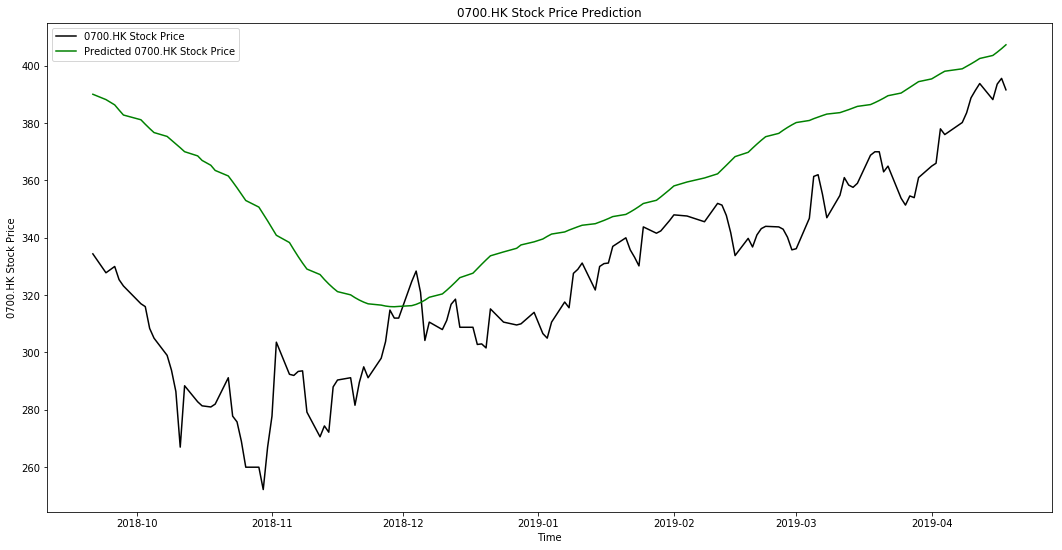

In [19]:
fig = plt.figure(figsize = (18,9))
plt.plot(date_predict,real_stock_price, color = 'black', label = '{} Stock Price'.format(stockCode))
plt.plot(date_predict,predicted_stock_price, color = 'green', label = 'Predicted {} Stock Price'.format(stockCode))
plt.title('{} Stock Price Prediction'.format(stockCode))
plt.xlabel('Time')
plt.ylabel('{} Stock Price'.format(stockCode))
plt.legend()
plt.show()

In [20]:
finishTime = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime()) 

In [22]:
regressor.save('trained_model/model/{}_model_{}.h5'.format(stockCode,finishTime))  # creates a HDF5 file 'my_model.h5'
# 將參數儲存至 HDF5 檔案（不含模型）
regressor.save_weights('trained_model/model_weight/{}_model_weights_{}.h5'.format(stockCode,finishTime))

In [23]:
fig.savefig('img/{}_{}.png'.format(stockCode,finishTime))

In [24]:
# Converting to Plotly's Figure object..
# plotly_fig = tls.mpl_to_plotly(fig)
plotly_fig = py.plot_mpl(fig, filename="my first plotly plot")

/Users/ShInGSon/anaconda3/lib/python3.6/site-packages/plotly/matplotlylib/renderer.py:390: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/Users/ShInGSon/anaconda3/lib/python3.6/site-packages/plotly/matplotlylib/renderer.py:487: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



In [26]:
print(plotly_fig)

https://plot.ly/~zinxon/34
